# Clean load and imputation of Data (EDA)

**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.api import SARIMAX
from IPython.display import clear_output
from math import pow

**Loading the Dataset**

In [ ]:
sales = pd.read_csv("/content/SalesFINAL12312016.csv")
purchase = pd.read_csv("/content/PurchasesFINAL12312016.csv")
invoice = pd.read_csv("/content/InvoicePurchases12312016.csv")
end_inv = pd.read_csv("/content/EndInvFINAL12312016.csv")
beg_inv = pd.read_csv("/content/BegInvFINAL12312016.csv")
purchase_price = pd.read_csv("/content/2017PurchasePricesDec.csv")

**Column description of the Dataset**

In [ ]:
print("purchase_price Columns:")
print(purchase_price.columns.tolist())

print("\nbeg_inv Columns:")
print(beg_inv.columns.tolist())

print("\nend_inv Columns:")
print(end_inv.columns.tolist())

print("\ninvoice Columns:")
print(invoice.columns.tolist())

print("\npurchase Columns:")
print(purchase.columns.tolist())

print("\nsales Columns:")
print(sales.columns.tolist())

purchase_price Columns:
['Brand', 'Description', 'Price', 'Size', 'Volume', 'Classification', 'PurchasePrice', 'VendorNumber', 'VendorName']

beg_inv Columns:
['InventoryId', 'Store', 'City', 'Brand', 'Description', 'Size', 'onHand', 'Price', 'startDate']

end_inv Columns:
['InventoryId', 'Store', 'City', 'Brand', 'Description', 'Size', 'onHand', 'Price', 'endDate']

invoice Columns:
['VendorNumber', 'VendorName', 'InvoiceDate', 'PONumber', 'PODate', 'PayDate', 'Quantity', 'Dollars', 'Freight', 'Approval']

purchase Columns:
['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'VendorNumber', 'VendorName', 'PONumber', 'PODate', 'ReceivingDate', 'InvoiceDate', 'PayDate', 'PurchasePrice', 'Quantity', 'Dollars', 'Classification']

sales Columns:
['InventoryId', 'Store', 'Brand', 'Description', 'Size', 'SalesQuantity', 'SalesDollars', 'SalesPrice', 'SalesDate', 'Volume', 'Classification', 'ExciseTax', 'VendorNo', 'VendorName']


**Understanding Missing Data**

In [ ]:
datasets = [purchase_price, beg_inv, end_inv, sales, purchase, invoice]
dataset_names = ['purchase_price', 'beg_inv', 'end_inv', 'sales', 'purchase', 'invoice']

for name, data in zip(dataset_names, datasets):
    missing_values = data.isnull().sum()
    non_zero_missing_values = missing_values[missing_values > 0]

    if not non_zero_missing_values.empty:
        print(f"\nMissing values found in {name}:")
        print(non_zero_missing_values)


Missing values found in purchase_price:
Description    1
Size           1
Volume         1
dtype: int64

Missing values found in end_inv:
City    1284
dtype: int64

Missing values found in purchase:
Size    3
dtype: int64

Missing values found in invoice:
Approval    5169
dtype: int64


 *Handling missing value is a cruicial part of the Data Analysis .Different Data may require different type of aproaches .Will try to evaluate each dataset and determine the most suitable Approach for identfying the missing values*

**purchase_price**

*   **Description,size,volume -** The number of missing entries here is minimal. We have two options: either remove these specific rows or take a more informed approach by filling the gaps with the most frequently occurring value (mode). We'll opt for removing these rows.

**end_inv**

*   **City-** All the city With NAN value are filled with a common name city present in the corresponding region ('TYWARDREATH')

**purchase**

*   **Size-** By removing these rows, you ensure that your subsequent analysis or modeling steps are not affected by missing data in the 'Size' column

**invoice**

*   **Approval-** Replace all NaN values in the 'Approval' column of the 'invoice' DataFrame with the string 'Pending'.


















In [ ]:
#purchase_price
cols_to_check = ['Description', 'Size', 'Volume']
purchase_price = purchase_price.dropna(subset=cols_to_check)

#end_inv
end_inv.City = end_inv.City.fillna('TYWARDREATH')
end_inv.InventoryId = end_inv.InventoryId.str.replace('__','_TYWARDREATH_')

#purchase
purchase = purchase[purchase['Size'].notna()]

#invoice
invoice['Approval'].fillna('Pending', inplace=True)

<ipython-input-5-9380993fd458>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  invoice['Approval'].fillna('Pending', inplace=True)


**Confirming Data Completeness**

In [ ]:
datasets = [purchase_price, beg_inv, end_inv, sales, purchase, invoice]
dataset_names = ['purchase_price', 'beg_inv', 'end_inv', 'sales', 'purchase', 'invoice']

for name, data in zip(dataset_names, datasets):
    missing_values = data.isnull().sum()
    non_zero_missing_values = missing_values[missing_values > 0]

    if not non_zero_missing_values.empty:
        print(f"\nMissing values found in {name}:")
        print(non_zero_missing_values)
    else :
        print(f"No missing values found in {name}")


No missing values found in purchase_price
No missing values found in beg_inv
No missing values found in end_inv
No missing values found in sales
No missing values found in purchase
No missing values found in invoice


**Inventory analysis will be restricted to the first two months of the year due to the limited availability of sales data.**

In [ ]:
purchases = purchase.loc[purchase.ReceivingDate<'2016-03-01']

#Initial Assessment

In [ ]:
total_stock_1 = beg_inv[['Brand','onHand','Price']]
total_stock_1.columns = ['Brand','Quantity','Price']
total_stock_1 = total_stock_1.groupby(['Brand','Price']).sum().reset_index()
purchases_with_prices = pd.merge(purchase,purchase_price[['Brand','Price']],on='Brand',how='left')
total_stock_2 = purchases_with_prices[['Brand','Quantity','Price']]
total_stock_2 = total_stock_2.groupby(['Brand','Price']).sum().reset_index()
total_stock = pd.concat([total_stock_1, total_stock_2]).reset_index(drop=True)
total_stock

,Brand,Price,Quantity
0,58,12.99,281
1,60,10.99,288
2,61,13.99,12
3,62,36.99,384
4,63,38.99,365
...,...,...,...
18752,90089,119.99,32
18753,90090,649.99,6
18754,90604,119.99,118
18755,90609,24.99,321


In [ ]:
sales_avg_price = sales[['Brand','SalesQuantity','SalesDollars']].groupby(['Brand']).sum().reset_index()
sales_avg_price['avg_price'] = sales_avg_price.SalesDollars.div(sales_avg_price.SalesQuantity)

In [ ]:
total_stock_sold_prices = pd.merge(total_stock, sales_avg_price[['Brand','avg_price']], on='Brand',how='left')
total_stock_sold_prices.avg_price = total_stock_sold_prices.avg_price.fillna(total_stock_sold_prices.Price)
total_stock_sold_prices = total_stock_sold_prices.drop('Price',axis=1)
total_stock_sold_prices = total_stock_sold_prices.groupby(['Brand','avg_price']).sum().reset_index()
total_stock_sold_prices = total_stock_sold_prices.groupby('Brand').agg({'avg_price':'min','Quantity':'sum'}).reset_index()
total_stock_sold_prices

,Brand,avg_price,Quantity
0,58,12.990000,3831
1,60,10.957742,1921
2,61,13.990000,324
3,62,40.446790,3584
4,63,42.386947,3220
...,...,...,...
11480,90089,119.990000,283
11481,90090,649.990000,57
11482,90604,119.990000,118
11483,90609,24.990000,321


In [ ]:
# Group by 'Brand' and calculate total sales and quantity
total_sales_by_brand = sales.groupby('Brand')[['SalesDollars', 'SalesQuantity']].sum().reset_index()

# Add a new column for average price
total_sales_by_brand['avg_price'] = total_sales_by_brand['SalesDollars'] / total_sales_by_brand['SalesQuantity']

total_sales_by_brand


,Brand,SalesDollars,SalesQuantity,avg_price
0,58,3741.12,288,12.990000
1,60,1358.76,124,10.957742
2,61,335.76,24,13.990000
3,62,6552.38,162,40.446790
4,63,5552.69,131,42.386947
...,...,...,...,...
7653,90084,63.98,2,31.990000
7654,90085,73.98,2,36.990000
7655,90086,51.99,1,51.990000
7656,90087,469.99,1,469.990000


In [ ]:
# Group by 'Brand' and calculate total quantity and total paid
paid_by_brand = purchases_with_prices.groupby('Brand')[['Quantity', 'Dollars']].sum().reset_index()

# Add a new column for the average amount paid
paid_by_brand['avg_paid'] = paid_by_brand['Dollars'] / paid_by_brand['Quantity']

paid_by_brand


,Brand,Quantity,Dollars,avg_paid
0,58,3550,32944.00,9.28
1,60,1633,12084.20,7.40
2,61,312,3307.20,10.60
3,62,3200,91744.00,28.67
4,63,2855,86963.30,30.46
...,...,...,...,...
10658,90089,32,2493.44,77.92
10659,90090,6,2689.62,448.27
10660,90604,118,9253.56,78.42
10661,90609,321,5457.00,17.00


In [ ]:
total_profit_by_brand = pd.merge(total_sales_by_brand,paid_by_brand[['Brand','avg_paid']],on='Brand',how='left')
total_profit_by_brand['avg_markup'] = total_profit_by_brand.avg_price.div(total_profit_by_brand.avg_paid).sub(1)
total_profit_by_brand.avg_paid = total_profit_by_brand.avg_paid.fillna(total_profit_by_brand.avg_price.mul(1-total_profit_by_brand.avg_markup.mean()))
total_profit_by_brand['avg_profit'] = total_profit_by_brand.avg_price.sub(total_profit_by_brand.avg_paid)
total_profit_by_brand['total_value'] = total_profit_by_brand.SalesQuantity.mul(total_profit_by_brand.avg_profit)
total_profit_by_brand.head()

,Brand,SalesDollars,SalesQuantity,avg_price,avg_paid,avg_markup,avg_profit,total_value
0,58,3741.12,288,12.990000,9.28,0.399784,3.710000,1068.48
1,60,1358.76,124,10.957742,7.40,0.480776,3.557742,441.16
2,61,335.76,24,13.990000,10.60,0.319811,3.390000,81.36
3,62,6552.38,162,40.446790,28.67,0.410770,11.776790,1907.84
4,63,5552.69,131,42.386947,30.46,0.391561,11.926947,1562.43


In [ ]:
print(f'Total SKUs: {len(total_stock_sold_prices):,}')
print(f'Total current stock: {end_inv.onHand.sum():,}')
print(f'Total items sold (two months): {total_profit_by_brand.SalesQuantity.sum():,}')
print(f'Total revenue: ${total_sales_by_brand.SalesDollars.sum():,.2f}')
print(f'Total profit: ${total_profit_by_brand.SalesDollars.sum():,.2f}')
print(f'Items were sold for prices between ${sales.SalesPrice.min():,.2f} and ${sales.SalesPrice.max():,.2f}')

Total SKUs: 11,485
Total current stock: 4,885,776
Total items sold (two months): 2,451,169
Total revenue: $33,139,375.29
Total profit: $33,139,375.29
Items were sold for prices between $0.49 and $4,999.99


# Time Series Analysis and Forecasting using ARIMA Model (Demand Forecasting)

**Grouping The Data By Date and merging**

In [ ]:
sales['SalesDate'] = pd.to_datetime(sales['SalesDate'])

In [ ]:
df2 = sales['SalesDate']

In [ ]:
# * group by date, sum sales quantity to get total sales quantity per day
sales_quantity_price = sales.groupby("SalesDate").agg({"SalesQuantity": "sum"})

In [ ]:
df1 = sales_quantity_price.copy()

In [ ]:
merged_df = pd.merge(df1, sales['SalesDate'], on='SalesDate', how='left')

In [ ]:
merged_df.columns

Index(['SalesDate', 'SalesQuantity'], dtype='object')

**Loading The Arima Model,Autoregressive Moving Average**

In [ ]:
mod = SARIMAX(sales_quantity_price,order=(5, 1, 1),type="c")
res = mod.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['type']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


**Add Future Dates and Predict**

In [ ]:
for i in pd.date_range("2016-03-01", "2016-03-31", freq="D"):
    sales_quantity_price.loc[i, "SalesQuantity"] = None
sales_quantity_price["forecast"] = res.predict(1, 90)

**Visualise**

In [ ]:
clear_output()
px.line(sales_quantity_price, x=sales_quantity_price.index, y=["SalesQuantity","forecast"]).show()

**Calculate Mean Absolute Percentage Error (MAPE)**

In [ ]:
absolute_diff = abs(sales_quantity_price["SalesQuantity"] - sales_quantity_price["forecast"])
relative_diff = absolute_diff / sales_quantity_price["SalesQuantity"] * 100
print("\n MAPE:",relative_diff.dropna().mean())


 MAPE: 59.16774438622555


**Calculate
𝑅^2
  (Coefficient of Determination)**

In [ ]:
mean_actual = sales_quantity_price["SalesQuantity"].mean()

# Calculate the total sum of squares (SST)
sst = ((sales_quantity_price["SalesQuantity"] - mean_actual) ** 2).sum()

# Calculate the residual sum of squares (SSR)
ssr = ((sales_quantity_price["SalesQuantity"] - sales_quantity_price["forecast"]) ** 2).sum()

# Calculate R^2
r2 = 1 - (ssr / sst)
print(f'R^2: {r2}')

R^2: 0.6958413424597891


**Identify High Relative Errors**

In [ ]:
print(relative_diff.sort_values(ascending=False).head(3))

SalesDate
2016-02-01    837.824424
2016-02-04    737.133405
2016-02-05    264.263724
dtype: float64




**Demand Forecasting:**

Defining sales quantity as demand, the graph reveals pronounced weekly and monthly seasonality. Peaks occur consistently on Thursdays and Fridays, likely due to vendor restocking, and significantly decline on Sundays, a company holiday. A notable monthly peak at January 29th (Thursday/Friday) with 180k sales sharply drops to 16.7k in early February, a 9% reduction, confirming strong monthly seasonality.

For forecasting, an Autoregressive Moving Average (ARMA) model was initially employed. Model parameters were manually selected to achieve low error and high R-squared. Despite achieving an R-squared of 0.7, the MAPE remains high at 59%, primarily due to the abrupt February sales decline. This significant error on February 1st, exceeding 800%, is expected given the model's struggle to capture the sharp monthly drop.

To improve the model, we must:

1.   Increase data availability: A longer data history will improve model accuracy.
2.   Incorporate seasonality: Explicitly account for weekly and monthly seasonality, with a particular focus on the pronounced monthly fluctuations.

3.   Forecast March quantity: Based on the current model, a preliminary forecast for March sales is 254,853 units.

**Calculate Forecasted Total Demand for March**

In [ ]:
print("May Forecast Total Demand: ",sales_quantity_price.loc["2016-03-01":"2016-03-31", "forecast"].sum())

May Forecast Total Demand:  254853.52898825431


In [ ]:
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.linear_model import LinearRegression

**Grouping and Preprocessing Data**

In [ ]:
sales_quantity_price = sales.groupby("SalesDate").agg({"SalesQuantity": "sum"})
sales_quantity_price.index = pd.to_datetime(sales_quantity_price.index)
sales_quantity_price['week'] = sales_quantity_price.index.month
sales_quantity_price['day'] = sales_quantity_price.index.dayofweek

**Fourier Terms for Seasonality**

In [ ]:
fourierM = CalendarFourier(freq="ME", order=6)

**Deterministic Process**

In [ ]:
dp = DeterministicProcess(
    index=sales_quantity_price.index,
    constant=True,
    order=4,
    seasonal=True,
    additional_terms=[fourierM],
)

**Linear Regression Model**

In [ ]:
X = dp.in_sample()
model = LinearRegression().fit(X, sales_quantity_price['SalesQuantity'])

**Forecasting**

In [ ]:
y_pred = pd.Series(
  model.predict(X),
  index = X.index,
  name="fitted"
)

**Visualizing Results**

<Axes: xlabel='SalesDate'>

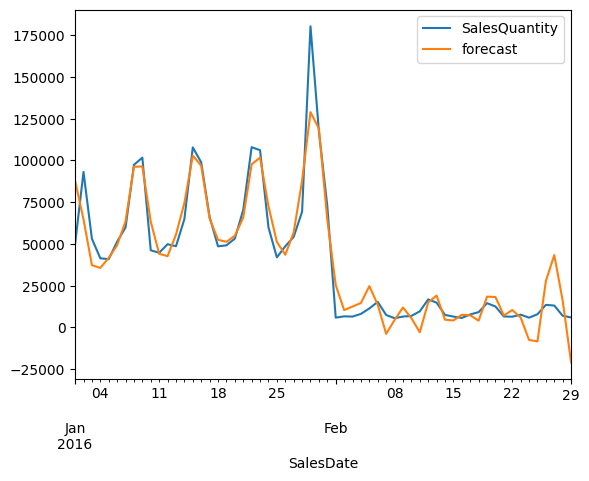

In [ ]:
sales_quantity_price["forecast"] = y_pred
sales_quantity_price[["SalesQuantity", "forecast"]].plot()

**This process involves creating a model to forecast daily sales based on patterns observed in historical data. It uses advanced techniques to account for trends, seasonality, and cyclic patterns in sales. By analyzing changes over time—such as monthly and weekly variations—the model predicts future sales. This approach is particularly useful for identifying how sales fluctuate due to recurring patterns or growth trends, even with limited data. The resulting forecast can help businesses plan inventory, optimize operations, and meet demand effectively.**

#ABC Analysis

**ABC analysis is used to divide SKUs into high, medium, and low value to the company.**



In [ ]:
ABC = (
    sales.groupby("Brand")
    .agg({"SalesQuantity": "sum"})
    .sort_values("SalesQuantity", ascending=False)
)
display(
    "Top 5 Demand",
    ABC.head(),
    "Bottom 5 Demand",
    ABC.tail(),
    "describe data",
    ABC.describe().T,
)
bins = [0, 100, 1000, 30000]
labels = ["C: <100", "B: 100-1k", "A: 1k-30k"]
ABC['bin'] = pd.cut(ABC["SalesQuantity"], bins, labels=labels)

'Top 5 Demand'

,SalesQuantity
Brand,
8111,28544
1892,23121
4261,20226
3606,19200
5111,18411


'Bottom 5 Demand'

,SalesQuantity
Brand,
17576,1
4308,1
4260,1
4164,1
5114,1


'describe data'

,count,mean,std,min,25%,50%,75%,max
SalesQuantity,7658.0,320.079525,1015.017597,1.0,10.0,49.0,238.0,28544.0


Text(0, 0.5, 'Frequency')

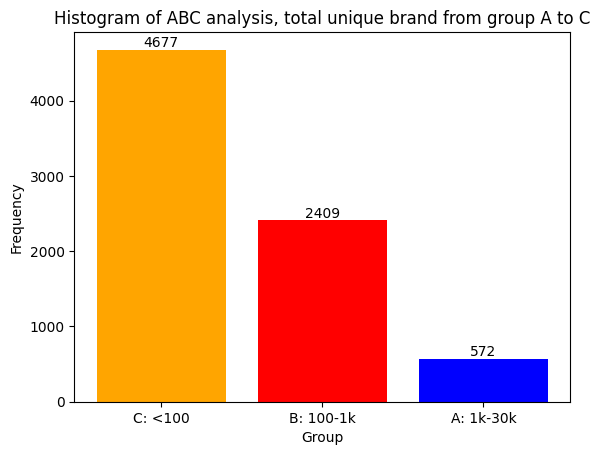

In [ ]:
plt.bar(ABC['bin'].value_counts().index, ABC['bin'].value_counts().values, color=['orange','red','blue'])
for i, value in enumerate(ABC['bin'].value_counts().values):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.title('Histogram of ABC analysis, total unique brand from group A to C')
plt.xlabel('Group')
plt.ylabel('Frequency')

In [ ]:
total_group = ABC.groupby('bin').agg({"SalesQuantity":'sum'})['SalesQuantity']
total = px.histogram(total_group.value_counts(), x=total_group.index, y=total_group.values, color=total_group.index, title="ABC analysis, total sales of brand from group A to C",text_auto=True)
total.update_layout(
  width=800,
  height=600,
    xaxis_title='Group',
    yaxis_title='Total_sales',
    bargap=0.2,  # Gap between bars
)
total.show()

<ipython-input-37-c2545ad48e9c>:1: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



**An ABC analysis was performed to categorize brands based on their sales volume. Brands with sales exceeding 1,000 units were classified as Category A, those with sales between 100 and 1,000 units as Category B, and those with less than 100 units as Category C. While Category C comprises the majority of brands (4677), its total sales volume (114k) is significantly lower than Category A (1.5 million), which represents only 12% of the total brands. This analysis underscores the importance of focusing on Category A brands in inventory management and exploring strategies to improve the performance of brands in Categories B and C, such as research and development, enhanced marketing, and optimized supply chains.**

# Calculate Economic Order Quantity (optimal stock-EOQ)



**Economic Order Quantity (EOQ) represents the optimal order size that minimizes the combined costs of ordering and holding inventory.
Calculating EOQ requires understanding the Order Placement Cost (OPC) and the Stock Ownership Cost (SOC). OPC quantifies the expense of placing an order, while SOC represents the cost of holding inventory.
These costs vary significantly across contexts and require specific data not available in this dataset. Therefore, I'm using estimated values: $30 for OPC and 10% of an item's value for annual SOC. Ideally, SOC would also consider the item's size, which will be explored in future analysis.**


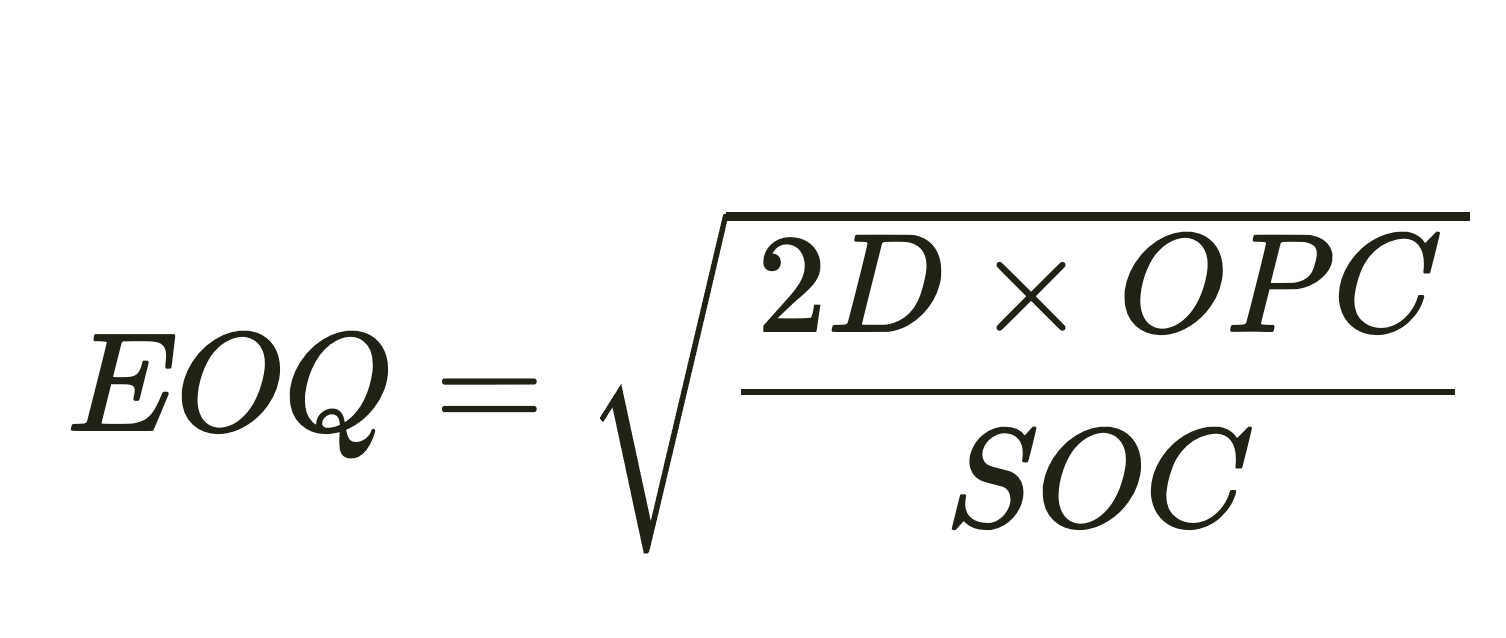

In [ ]:
df = total_profit_by_brand

In [ ]:
df['sales_mean'] = df['SalesQuantity'].mean()

In [ ]:
OPC = 30 #Order Placement Cost, chosen arbitrarily
SOC = df.avg_price.mul(.1).div(365) #Stock Ownership Cost, ratio to average price chosen arbitarily
df['EOQ'] = df.sales_mean.mul(2).mul(OPC).div(SOC).pow(.5).round()
df[['Brand','EOQ']].head()

,Brand,EOQ
0,58,2323.0
1,60,2529.0
2,61,2238.0
3,62,1316.0
4,63,1286.0


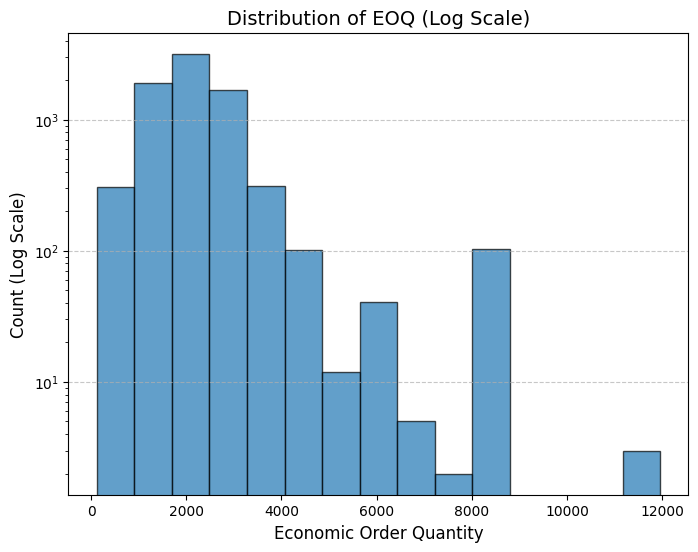

In [ ]:
eoq_data = df['EOQ']
eoq_data = eoq_data.replace([np.inf, -np.inf], np.nan).dropna()
plt.figure(figsize=(8, 6))
plt.hist(eoq_data, bins=15, alpha=0.7, edgecolor='black', log=True)
plt.title('Distribution of EOQ (Log Scale)', fontsize=14)
plt.xlabel('Economic Order Quantity', fontsize=12)
plt.ylabel('Count (Log Scale)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**This EOQ distribution graph highlights the variability in optimal order quantities across products. The clustering around specific ranges reveals demand patterns, while outliers indicate high-demand or high-cost items. The log scale emphasizes small-frequency differences, aiding identification of optimization opportunities. Insights can guide cost reduction, inventory balancing, and improved supply chain efficiency.**

# **Reorder Point Analysis**

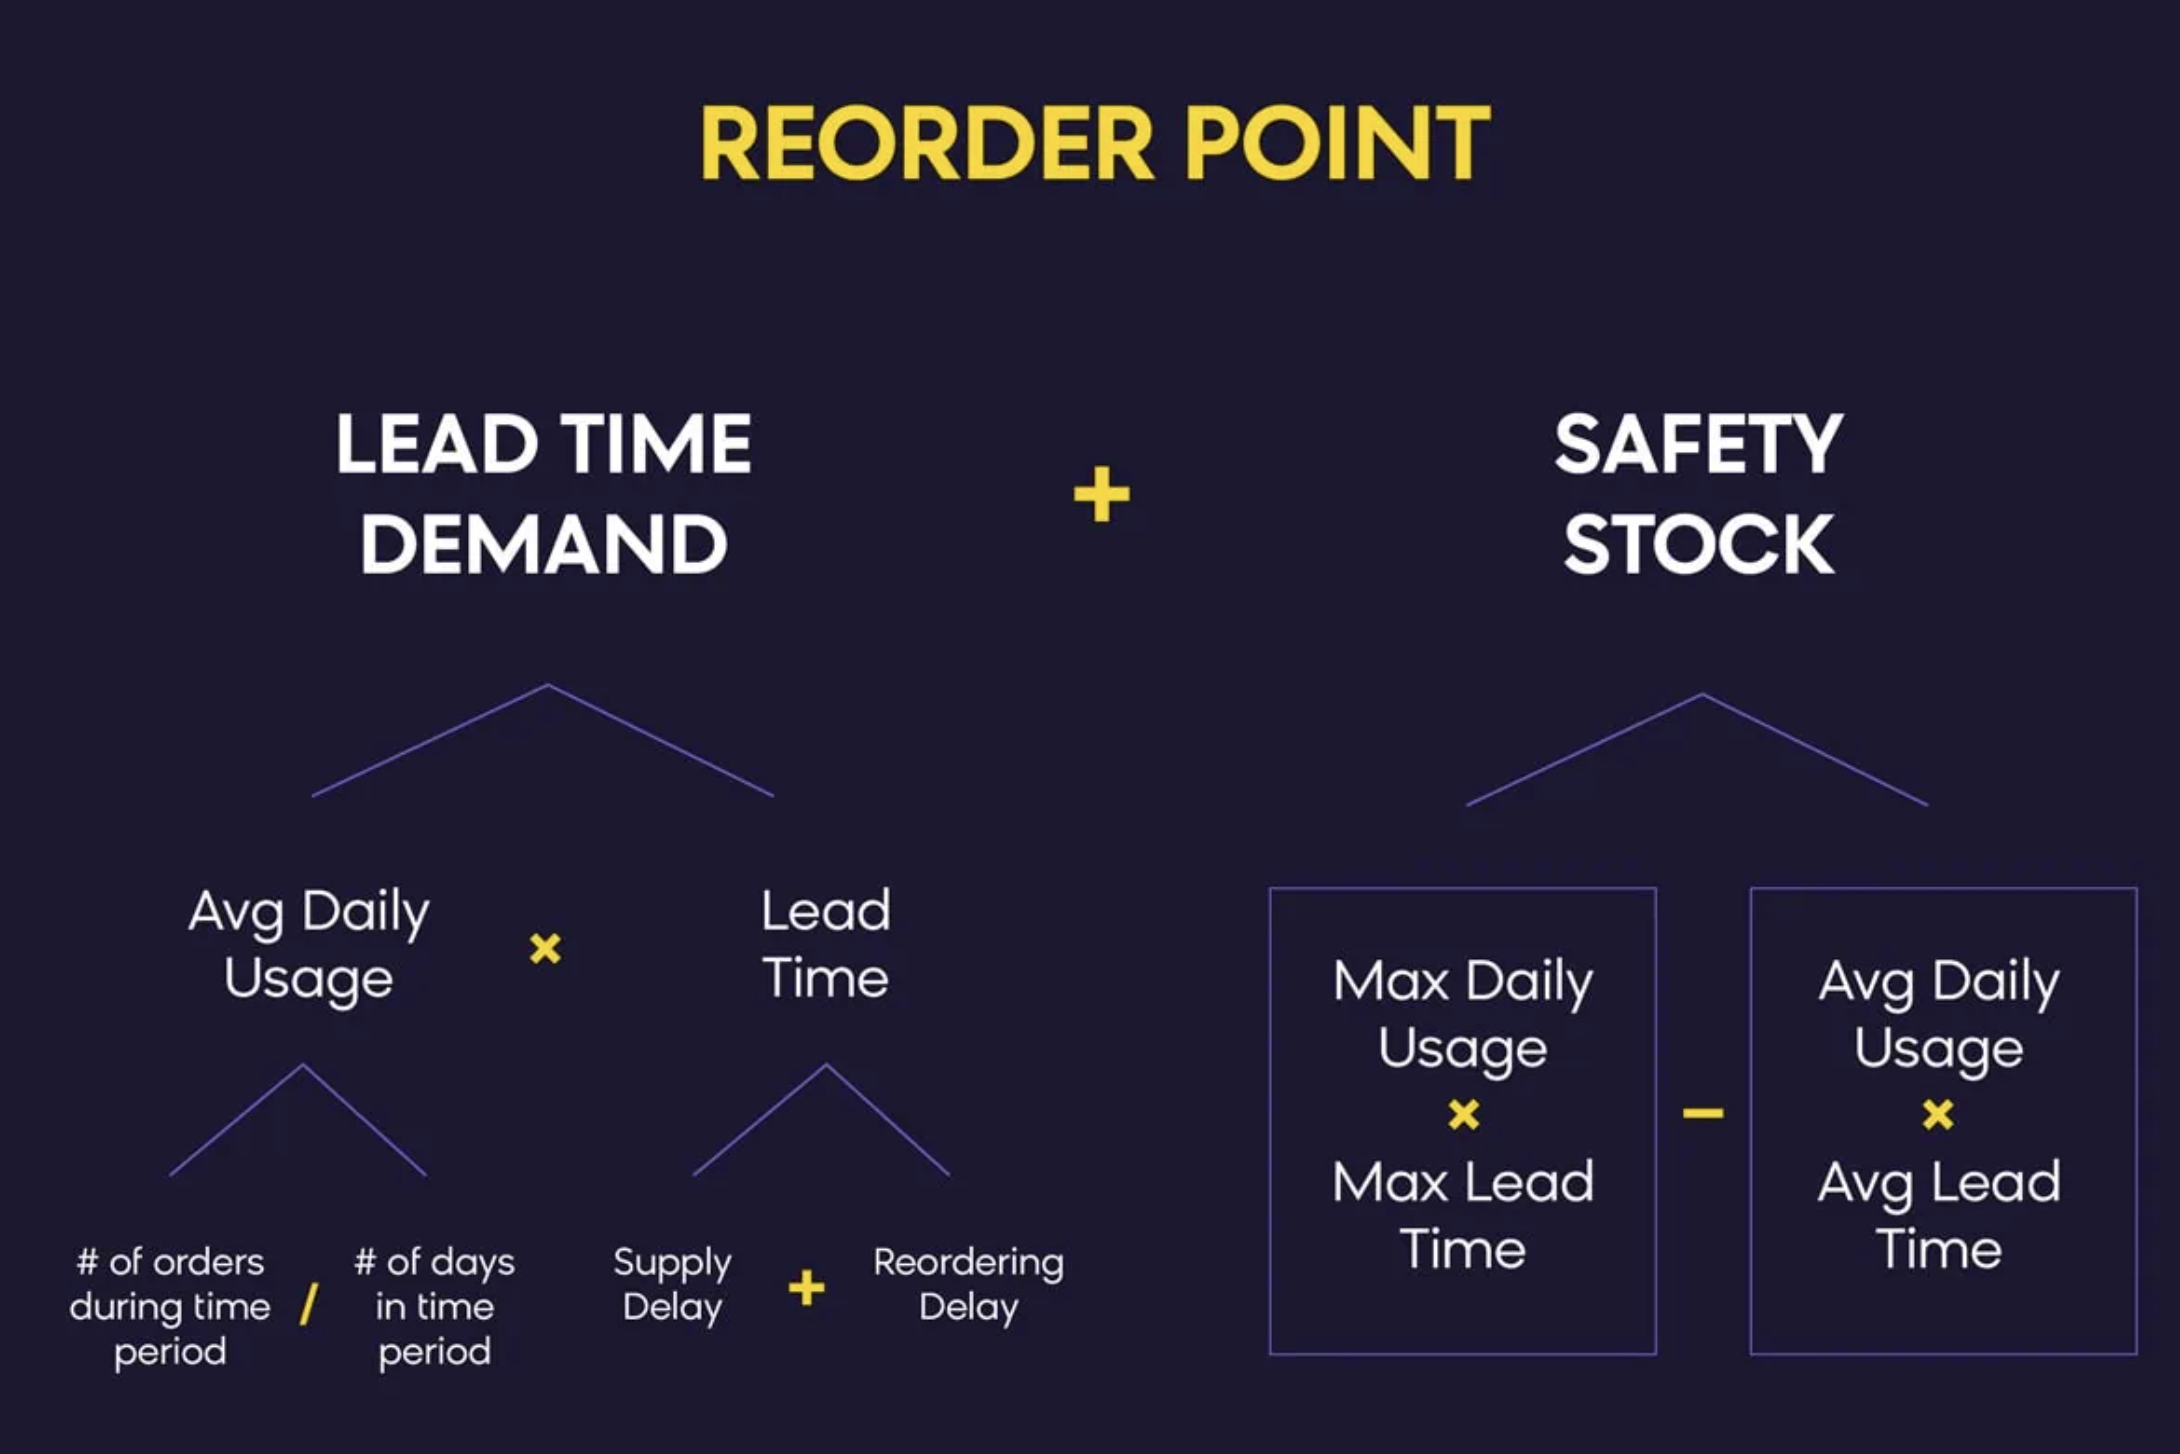

In [ ]:
# * Average Daily Usage
sales_velocity = (
    sales.groupby(["Brand", "Description"]).agg({"SalesQuantity": "sum"}).reset_index()
)
days = (
    pd.to_datetime(sales["SalesDate"]).max() - pd.to_datetime(sales["SalesDate"]).min()
).days
sales_velocity["mean_daily_sales"] = sales_velocity["SalesQuantity"] / days
mean_daily_sales = sales_velocity.set_index("Brand")["mean_daily_sales"]
display(mean_daily_sales.to_frame().T, mean_daily_sales.describe().to_frame().T)

Brand,58,60,61,62,63,72,75,77,79,82,...,90014,90025,90080,90081,90082,90084,90085,90086,90087,90089
mean_daily_sales,4.881356,2.101695,0.40678,2.745763,2.220339,0.322034,0.050847,15.389831,7.050847,0.050847,...,0.237288,0.20339,0.322034,0.118644,0.050847,0.033898,0.033898,0.016949,0.016949,0.457627


,count,mean,std,min,25%,50%,75%,max
mean_daily_sales,7658.0,5.425077,17.203688,0.016949,0.169492,0.830508,4.033898,483.79661


In [ ]:
# * Lead Time
purchase["lead_time"] = (
    pd.to_datetime(purchase["ReceivingDate"]) - pd.to_datetime(purchase["PODate"])
).dt.days
lead_time_brand = purchase.groupby("Brand").agg({"lead_time": "mean"})
display(lead_time_brand.T, lead_time_brand.describe().T)

Brand,58,60,61,62,63,70,72,75,77,79,...,90080,90085,90086,90087,90088,90089,90090,90604,90609,90631
lead_time,7.758389,7.659794,8.115385,7.33157,7.324427,7.333333,8.636364,7.0,7.292162,7.270161,...,12.0,8.0,9.0,4.8,3.5,7.333333,4.5,7.384615,10.363636,9.21374


,count,mean,std,min,25%,50%,75%,max
lead_time,10663.0,7.81831,1.222808,3.0,7.277778,7.705882,8.294118,14.0


In [ ]:
# * Safety Stock
max_sales_brand = sales.groupby("Brand").agg({"SalesQuantity": "max"})
safety_stock = (
    max_sales_brand["SalesQuantity"]
    - sales_velocity.set_index("Brand")["mean_daily_sales"]
)
display(safety_stock.to_frame().T, safety_stock.describe().to_frame().T)
# * notice there are negatives to fix this problem we will just set them to 0
safety_stock[safety_stock < 0] = 0

Brand,58,60,61,62,63,72,75,77,79,82,...,90014,90025,90080,90081,90082,90084,90085,90086,90087,90089
0,2.118644,0.898305,11.59322,0.254237,1.779661,2.677966,0.949153,-7.389831,-2.050847,2.949153,...,11.762712,9.79661,7.677966,5.881356,1.949153,0.966102,1.966102,0.983051,0.983051,11.542373


,count,mean,std,min,25%,50%,75%,max
0,7658.0,6.12794,16.949081,-356.79661,1.508475,3.762712,9.525424,407.966102


In [ ]:
reorder_point = ((mean_daily_sales * lead_time_brand['lead_time']) + safety_stock).round()
reorder_point.name = "Reorder Point"
reorder_point.dropna(inplace=True)
reorder_point = reorder_point.to_frame()
reorder_point['ABC'] = ABC['bin']
display(reorder_point , reorder_point.describe())


,Reorder Point,ABC
Brand,,
58,40.0,B: 100-1k
60,17.0,B: 100-1k
61,15.0,C: <100
62,20.0,B: 100-1k
63,18.0,B: 100-1k
...,...,...
90080,12.0,C: <100
90085,2.0,C: <100
90086,1.0,C: <100


,Reorder Point
count,7146.000000
mean,51.934929
std,136.539770
min,1.000000
25%,6.000000
50%,16.000000
75%,46.000000
max,3687.000000


In [ ]:
fig = px.histogram(
    reorder_point, x="Reorder Point", color="ABC", nbins=50, title="Reorder Point Analysis distribution", log_y=True
)
fig.update_layout(
    bargap=0.2,
    xaxis_title_text="total_count_brand",  # xaxis label
    yaxis_title_text="ReorderPointBin",  # yaxis label

)
fig.show()

**The reorder point signifies the minimum stock level triggering a replenishment order. Reorder Point is dynamic, influenced by purchase and sales cycles, and unique to each product. Its primary purpose is to prevent stockouts while mitigating overstocking, thereby optimizing shipping costs and enhancing forecasting accuracy.**

**Discussion:**

**In this analysis, safety stock is defined as the difference between maximum daily sales and average daily sales for a brand. The Reorder Point Analysis Distribution reveals that a majority of brands (6304 out of 7146), primarily from the C category, have Reorder Point values between 0 and 99 units. Conversely, a few outliers, predominantly from the high-demand, high-priority A category, exhibit significantly higher ROP values reaching thousands of units. This aligns with expectations, as the rapid sales velocity of A-level brands necessitates larger reorder Points to prevent stockouts. Furthermore, the consistent demand for A-level products, unlike the infrequent orders for C-level products, ensures a smoother product flow and minimizes inventory holding costs.**

#**Lead Time Analysis**

In [ ]:
fig = px.histogram(lead_time_brand, x='lead_time', nbins=50, title="Lead Time Analysis distribution",text_auto=True)
fig.update_layout(
    bargap=0.1,
    xaxis_title_text="average_lead_time",  # xaxis label
    yaxis_title_text="total_count_brand",  # yaxis label
    height=600
)
fig.show()

**Lead time, defined as the interval between initiating a purchase order and receiving the shipment, is a critical factor in production and inventory management. This analysis reveals a generally normal distribution of average lead times, with a majority of brands experiencing lead times exceeding one week. Notably, a cluster of brands exhibits exceptionally low lead times, ranging from approximately 2.75 to 3.25 days. To effectively manage inventory and prevent stockouts, it is imperative to implement an ordering strategy that accounts for these extended lead times. Specifically, new orders should be placed at least one or two weeks in advance to ensure adequate inventory levels and avoid falling below safety stock thresholds.**

#**Carying Cost Analysis**

In [ ]:
annual_inventory_value = end_inv.copy()
annual_inventory_value["total_value"] = (
    annual_inventory_value["onHand"] * annual_inventory_value["Price"]
)

In [ ]:
brand_inventory_value = annual_inventory_value.groupby("Brand").agg(
    {"Price": "first", "Description": "first", "total_value": "sum", "onHand": "sum"}
)

In [ ]:
brand_inventory_value["RPA"] = reorder_point["Reorder Point"]
brand_inventory_value["total_value_if_RPA"] = (
    brand_inventory_value["RPA"] * brand_inventory_value["Price"]
)
brand_inventory_value["total_value_saved_if_RPA"] = (
    brand_inventory_value["total_value"] - brand_inventory_value["total_value_if_RPA"]
)

In [ ]:
brand_inventory_value.sort_values("total_value", ascending=False, inplace=True)
brand_inventory_value.dropna(inplace=True)

In [ ]:
brand_inventory_value

,Price,Description,total_value,onHand,RPA,total_value_if_RPA,total_value_saved_if_RPA
Brand,,,,,,,
1233,34.99,Jack Daniels No 7 Black,526494.53,15047,1208.0,42267.92,484226.61
3545,29.99,Ketel One Vodka,502932.30,16770,1483.0,44475.17,458457.13
2753,59.99,Johnnie Walker Black Label,470861.51,7849,235.0,14097.65,456763.86
8068,23.49,Absolut 80 Proof,366631.92,15608,1413.0,33191.37,333440.55
3405,28.99,Tito's Handmade Vodka,355649.32,12268,1179.0,34179.21,321470.11
...,...,...,...,...,...,...,...
25201,18.99,Ch Croix de Jaugue St Emilio,0.00,0,21.0,398.79,-398.79
45993,10.99,Casa Liliana Good Merlot,0.00,0,3.0,32.97,-32.97
2943,119.99,The Macallan 18 Yr Old,0.00,0,1.0,119.99,-119.99


In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Histogram(
        x=brand_inventory_value["total_value"],
        name="end of year inventory",
        nbinsx=50,
    )
)
fig.add_trace(
    go.Histogram(
        x=brand_inventory_value["total_value_if_RPA"],
        name="if follow reorder point/optimal level",
        nbinsx=50,
    )
)
fig.update_yaxes(type="log")
fig.update_layout(
    title_text="Total Inventory Value Distribution",
    xaxis_title_text="total inventory value",  # xaxis label
    yaxis_title_text="total number of brands",  # yaxis label
    bargap=0.2,  # gap between bars of adjacent location coordinates
    bargroupgap=0.1,  # gap between bars of the same location coordinates
)

fig.show()

display(brand_inventory_value[['total_value','total_value_if_RPA','total_value_saved_if_RPA']].sum().apply(lambda x: f"${x:,.0f}").to_frame().T)
brand_inventory_value["total_value"] = brand_inventory_value["total_value"].apply(
    lambda x: f"${x:,.0f}"
)
brand_inventory_value["total_value_if_RPA"] = brand_inventory_value[
    "total_value_if_RPA"
].apply(lambda x: f"${x:,.0f}")
brand_inventory_value["total_value_saved_if_RPA"] = brand_inventory_value[
    "total_value_saved_if_RPA"
].apply(lambda x: f"${x:,.0f}")
display(brand_inventory_value.head(10), brand_inventory_value.tail(10))

,total_value,total_value_if_RPA,total_value_saved_if_RPA
0,"$70,395,768","$4,975,089","$65,420,680"


,Price,Description,total_value,onHand,RPA,total_value_if_RPA,total_value_saved_if_RPA
Brand,,,,,,,
1233,34.99,Jack Daniels No 7 Black,"$526,495",15047,1208.0,"$42,268","$484,227"
3545,29.99,Ketel One Vodka,"$502,932",16770,1483.0,"$44,475","$458,457"
2753,59.99,Johnnie Walker Black Label,"$470,862",7849,235.0,"$14,098","$456,764"
8068,23.49,Absolut 80 Proof,"$366,632",15608,1413.0,"$33,191","$333,441"
3405,28.99,Tito's Handmade Vodka,"$355,649",12268,1179.0,"$34,179","$321,470"
4261,20.99,Capt Morgan Spiced Rum,"$351,981",16769,2517.0,"$52,832","$299,149"
2757,28.99,Johnnie Walker Red Label,"$336,371",11603,662.0,"$19,191","$317,180"
2589,37.99,Jameson Irish Whiskey,"$300,957",7922,639.0,"$24,276","$276,681"
1376,20.99,Jim Beam,"$276,648",13180,915.0,"$19,206","$257,442"


,Price,Description,total_value,onHand,RPA,total_value_if_RPA,total_value_saved_if_RPA
Brand,,,,,,,
15729,2.49,Copa di Vino Pnt Grigio,$0,0,30.0,$75,$-75
12429,15.99,F Coppola Diamnd Petite Sira,$0,0,8.0,$128,$-128
19347,11.99,The Royal Chenin Blanc,$0,0,1.0,$12,$-12
3058,0.99,Three Olives Vodka,$0,0,15.0,$15,$-15
42797,18.49,Ricardo Santos Malbec Mendza,$0,0,29.0,$536,$-536
25201,18.99,Ch Croix de Jaugue St Emilio,$0,0,21.0,$399,$-399
45993,10.99,Casa Liliana Good Merlot,$0,0,3.0,$33,$-33
2943,119.99,The Macallan 18 Yr Old,$0,0,1.0,$120,$-120
24975,17.99,Tenshen White,$0,0,24.0,$432,$-432


**Discussion:**

**The company's year-end inventory value totaled $79 million. Analysis of the top 10 products by inventory value revealed significant discrepancies between actual inventory levels and those suggested by the reorder point model, which was based on only two months of sales data. This limited data scope introduces uncertainty, as actual sales patterns may have deviated from the initial two-month trend.**

**The reorder point model, if strictly adhered to, would have resulted in a total inventory value of approximately 5 million dollars, representing a potential savings of around $74 million compared to the actual inventory value. For the top 10 inventory value brands, this translates to potential savings of 250k to 500k. Considering a carrying cost of 20-25%, this could translate to annual savings of 50k to 100k dollars.**

**The analysis also highlighted instances where brands were out of stock at year-end, despite the reorder point suggesting sufficient inventory levels. This emphasizes the need for ongoing monitoring and adjustments to the reorder point model to account for evolving sales patterns and prevent stockouts. By optimizing inventory levels, the company can minimize carrying costs, reduce the risk of dead stock, and ensure product availability to meet customer demand.**

# **Inventory Turnover Analysis**

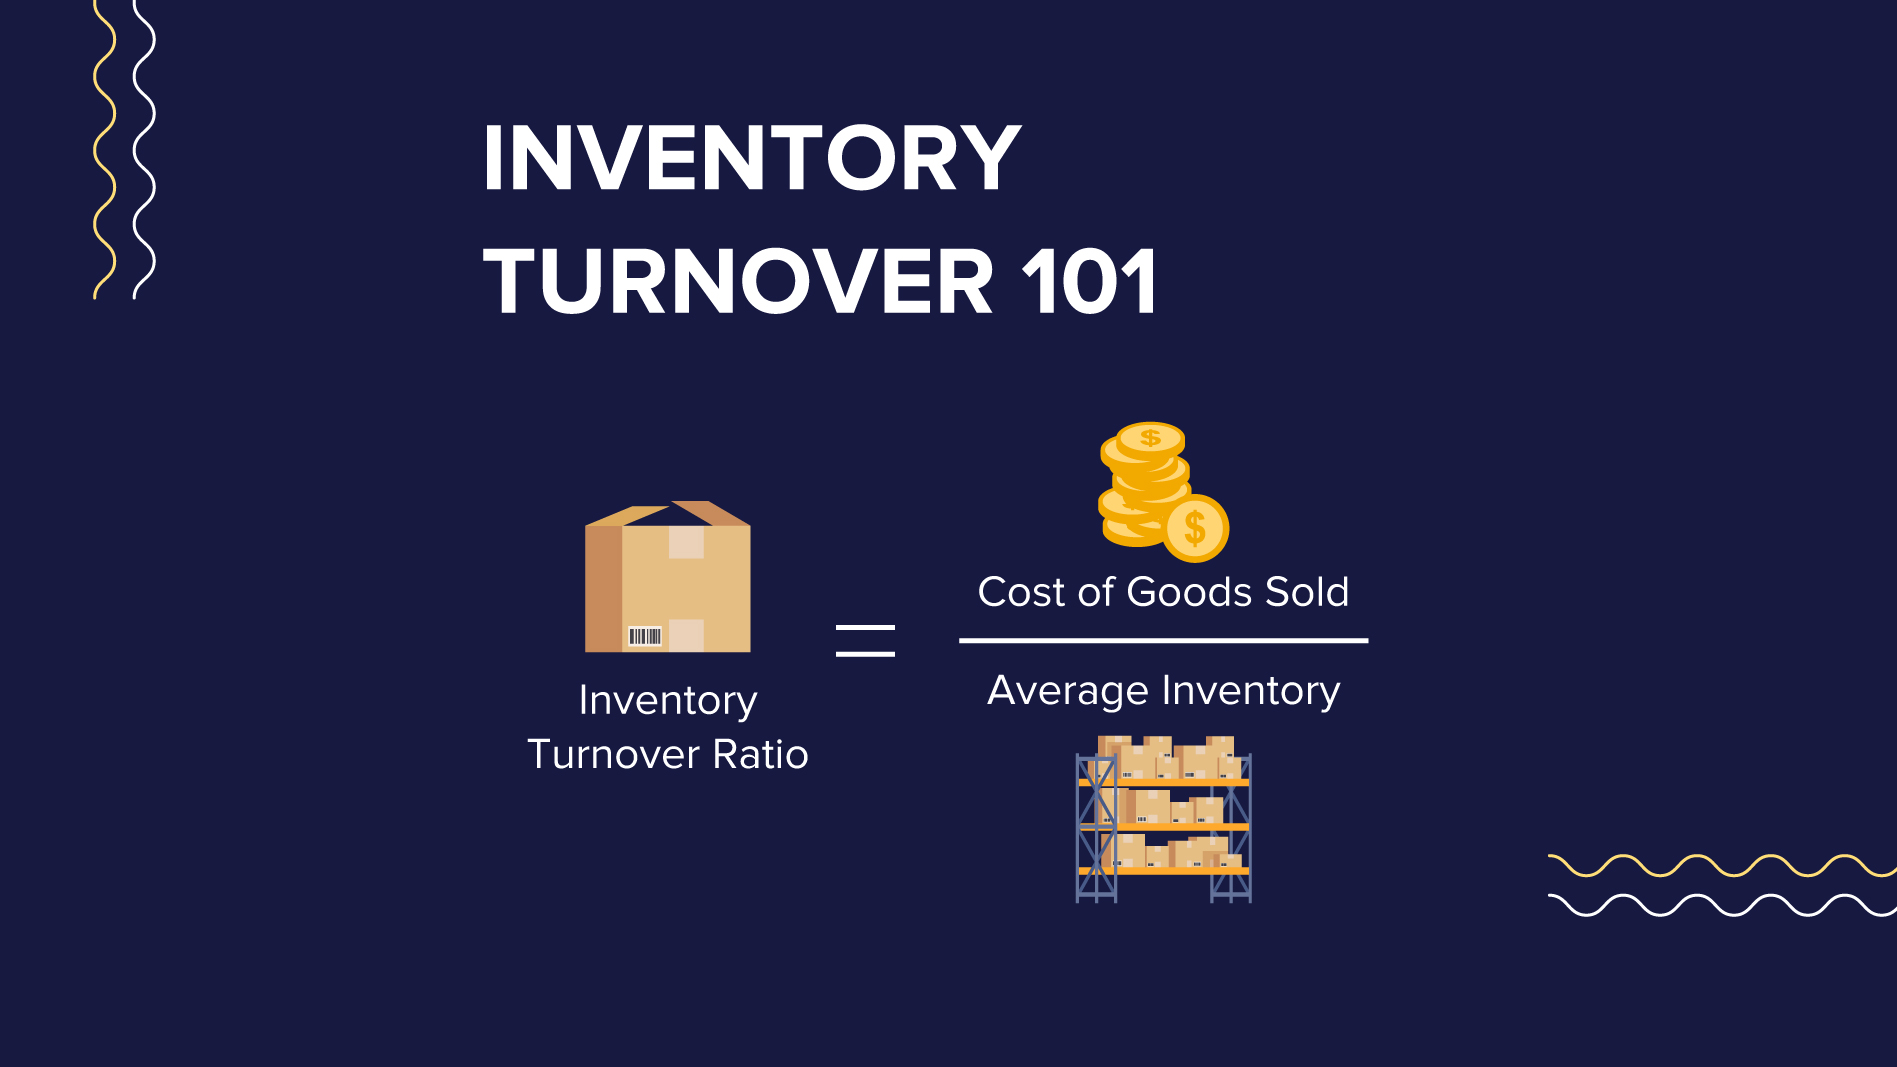

In [ ]:
brand_purchases = purchase.groupby("Brand").agg(TotalPurchaseAmount=("Dollars", "sum")).reset_index()
brand_purchases

,Brand,TotalPurchaseAmount
0,58,32944.00
1,60,12084.20
2,61,3307.20
3,62,91744.00
4,63,86963.30
...,...,...
10658,90089,2493.44
10659,90090,2689.62
10660,90604,9253.56
10661,90609,5457.00


In [ ]:
purchase_total = brand_purchases['TotalPurchaseAmount'].sum()

In [ ]:
beg_inv

,InventoryId,Store,City,Brand,Description,Size,onHand,Price,startDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,8,12.99,2016-01-01
1,1_HARDERSFIELD_60,1,HARDERSFIELD,60,Canadian Club 1858 VAP,750mL,7,10.99,2016-01-01
2,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,6,36.99,2016-01-01
3,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,3,38.99,2016-01-01
4,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,6,34.99,2016-01-01
...,...,...,...,...,...,...,...,...,...
206524,79_BALLYMENA_46985,79,BALLYMENA,46985,Rodney Strong Cab Svgn Alexa,750mL,13,22.99,2016-01-01
206525,79_BALLYMENA_47014,79,BALLYMENA,47014,Juan Gil Jumilla Rd,750mL,13,13.99,2016-01-01
206526,79_BALLYMENA_47090,79,BALLYMENA,47090,Napa Cellars Cab Svgn Napa,750mL,19,23.99,2016-01-01
206527,79_BALLYMENA_90011,79,BALLYMENA,90011,Ch Pichon Longville 12 Pauil,750mL,12,144.99,2016-01-01


In [ ]:
beg_inv_total = beg_inv['onHand']*beg_inv['Price']
beg_inv_total = beg_inv_total.sum()
beg_inv_total

68053780.17

In [ ]:
end_inv

,InventoryId,Store,City,Brand,Description,Size,onHand,Price,endDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,11,12.99,2016-12-31
1,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,7,36.99,2016-12-31
2,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,7,38.99,2016-12-31
3,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,4,34.99,2016-12-31
4,1_HARDERSFIELD_75,1,HARDERSFIELD,75,Three Olives Tomato Vodka,750mL,7,14.99,2016-12-31
...,...,...,...,...,...,...,...,...,...
224484,81_PEMBROKE_90087,81,PEMBROKE,90087,Ch Mouton Rothschild 12 Paui,750mL,3,469.99,2016-12-31
224485,81_PEMBROKE_90088,81,PEMBROKE,90088,Ch Le Petite Mouton 12 Pauil,750mL,3,134.99,2016-12-31
224486,81_PEMBROKE_90089,81,PEMBROKE,90089,Ch Lynch Bages 12 Pauillac,750mL,3,119.99,2016-12-31
224487,81_PEMBROKE_90090,81,PEMBROKE,90090,Ch Lafite Rothschild 12,750mL,3,649.99,2016-12-31


In [ ]:
end_inv_total = end_inv['onHand']*end_inv['Price']
end_inv_total = end_inv_total.sum()
end_inv_total

79704851.13

In [ ]:
COGS = beg_inv_total+purchase_total-end_inv_total
COGS

310249512.65000004

In [ ]:
avg_inv = beg_inv_total+end_inv_total
df1 = avg_inv/2
df1

73879315.65

In [ ]:
Ita = COGS/df1
Ita

4.1994096713049345

An inventory turnover ratio of 4.2 indicates that a company sells and replenishes its inventory approximately four times per year or every 86 days. This moderate turnover rate generally indicates efficient inventory management, leading to several benefits:

Reduced carrying costs: Lower inventory holding periods translate to lower storage, insurance, and opportunity costs.

Improved cash flow: Faster inventory movement accelerates cash recovery from sales.
Reduced risk of obsolescence: Minimizes the risk of products becoming outdated or unsaleable.

Enhanced customer satisfaction: Maintains sufficient stock to meet customer demand.

However, potential concerns include:

Risk of stockouts: If turnover is too high, it may increase the risk of stockouts due to insufficient safety stock.

Competitive pressures: Higher turnover rates among competitors could provide them with a competitive edge.

Data accuracy: Inaccurate inventory counts or sales data can skew the turnover ratio and lead to incorrect interpretations.

